# DSI Team Starting Point

### Background

DSI Phase I:
- Cleaned and Analyzed Historical CFPB Agreement Data looking to understand offered APRs
    - Team found initial analysis lacking in meaning due to the nature of the APR values reported in the agreements
        - The Reported APRs were listed as a "middle point" across customer segments per plan per agreement.
        - This ultiamtely meant that the APR value was already a range or a value from a range rather than the discreet values themselves.
    - Later found out from data stewards that the historical data is non-verifiable, meaning the reported APRs were hard to relate to the actual offerings at that time.
    - Data Teams Presentations:
        - <a href="https://github.com/chrisJoyceDS/top_sprint_data/blob/main/code/CFPB_Data.ipynb"> Jupyter Notebook Repo </a>
        - <a href="https://docs.google.com/presentation/d/16vBsI7b5Fw_0tF1UQK4qW2dn32v66PwcC3VZ959mx4c/edit#slide=id.p"> Presentation to the Team </a>
        - <a href="https://docs.google.com/presentation/d/18uy5qkw0zQTg-SA-ceXDKOI2dCI4RLN-IjSQXfIwCIM/edit#slide=id.p"> Presentation to the CFPB </a>

DSI Phase II:
- After having it confirmed that the historical data was innacurate and far from reality, the team learned of and used the updated dataset provided by the CFPB
- This data was from July 2022 to December 2022 and had a variety of updated information with respect to the historical data
- Unfortunately there is no data dictionary for this dataset, and we will have to interpet their values based on the column descriptions
- for the sake of the team, we left most of the column names intact, and update a few where we thought it was best/relevant
- Please follow us along or Select "Jump to Clustering" below:

[Jump to Clustering](#Clustering)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
import re
import missingno as msno

# imputing
from sklearn.impute import KNNImputer
# preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

- The dataset data doesn't fall on the usual A0 cell, we needed to adjust the pandas reader

In [ ]:
columns_to_read = 'B:FO'

In [ ]:
df = pd.read_excel("../data/cfpb_updated_tccp.xlsx",skiprows=9,usecols=columns_to_read)

In [ ]:
df.head()

In [ ]:
df.shape

- Key differences between this data set and the historical data set
    - This is not timeseries, it is each institution's plan data as of December 31 of the participants in the survey
    - Phase I dataset was (rows:9556,columns:12)
    - more dense of a dataset
- let's check out the null landscape below

In [ ]:
msno.matrix(df.sample(250))

- What you are seeing is a graphical representation of the data within the new data set:
    - Black means data
    - White means no data
- With more fields collected, comes the even possibility of not collecting it.
- Below is the start of our initial clean process. Because of the look of the dataset above, and the sheer amount of initial features we have (170) we are going to make some swift cuts

In [ ]:
df.info()

In [ ]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [ ]:
type(null_percentage)

In [ ]:
null_percentage.shape

In [ ]:
# set threshold
threshold = 90

In [ ]:
# Create a list of column names to drop where the null percentage is greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()

In [ ]:
len(columns_to_drop)

In [ ]:
# drop the columns
df.drop(columns=columns_to_drop,inplace=True)

In [ ]:
df.shape

- Above we:
    - Calculated the null percentage for each column of the 170
    - set a threshold of 90 percent null as the cut off
    - removed all columns that met that threshould and above
    - resulting in dropping 68 columns
- You can see the impact below, and it's much better, but we still have 102 features, which means we will be greedier in our selection

In [ ]:
msno.matrix(df.sample(250))

In [ ]:
df.head()

In [ ]:
# get remaining column data types
col_types = df.dtypes

In [ ]:
# separate out numerical and object columns
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [ ]:
df[num_cols].shape

In [ ]:
df[obj_cols].shape

In [ ]:
df[num_cols].isnull().sum().sum(), df[obj_cols].isnull().sum().sum()

In [ ]:
# re-Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [ ]:
null_percentage.sort_values(ascending=False)[null_percentage >= 59]

In [ ]:
# additional columns to drop
cols_to_drop = null_percentage[null_percentage >= 60].index.tolist()

In [ ]:
len(cols_to_drop)

In [ ]:
# drop additional columns
# drop the columns
df.drop(columns=cols_to_drop,inplace=True)

In [ ]:
df.info()

- Same exercise, new threshold, this time anything that was greater or equal to 59% null
- Now we have 68 Columns (5.5 times the features we had with historical btw) with a much better look of data below

In [ ]:
msno.matrix(df.sample(250))

In [ ]:
df.columns.shape

- Something you will have noticed, if you read our initial analysis, is that there are less visualizations for this data set
- There will be more going forward, but for now we have prioritized creating aggregate cards for the Software Engineering Team to be able to start building
- From this point we will be doing a mix of cleaning, feature engineering, preprocessing, and clustering

---
## MVP Goal

- Create Aggregate cards based on the targeted credit tiers 
- Capture APR, Grace Periods, Late Fees, Rewards, and Annual Fees

In [ ]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].apply(lambda x: x.lower())

In [ ]:
df["Targeted Credit Tiers"].value_counts()

- split the strings on the ';'
- for the non technical this just makes it easier for us to interact with
- Goes from:
    - good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater) 
    - to
    - ['good credit (credit scores from 620 to 719)',
 'great credit (credit score of 720 or greater)']

In [ ]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].str.split("; ")

- Create three columns that align with the credit score group.
- if the word is found in a given list of options for a specific group, report True, else False 

In [ ]:
# Create Separate Columns for each bucket
df['Poor_Fair_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'poor', s) for s in x))
df['Good_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'good', s) for s in x))
df['Great_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'great', s) for s in x))

In [ ]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']]

In [ ]:
# convert boolean into numerical values
df['Poor_Fair_Group'] = df['Poor_Fair_Group'].astype(int)
df['Good_Credit_Group'] = df['Good_Credit_Group'].astype(int)
df['Great_Credit_Group'] = df['Great_Credit_Group'].astype(int)

In [ ]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']].head()

In [ ]:
df.columns

In [ ]:
df.head()

Immediately, some of these columns are aparently redundant. For instance:

In [ ]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance']]

Whether an APR is offered is already represented in `Purchase APR Vary by Balance` because in cases where an APR is not offered, there will be a NaN. That said, I am going to have to impute these NaNs before I can cluster, so this relationship will be lost, but would be retained by `Purchase APR Offered?` if I decide to keep this feature.

Some other features I assume won't be useful:

In [ ]:
df[['Website for Consumer','Telephone Number for Consumers']]

Is there a real relationship between credit score and the URL/phone number of the company offering a credit card? Probably not. I'll drop these features.

In [ ]:
df.drop(columns = ['Website for Consumer','Telephone Number for Consumers'], inplace = True)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df[['Good Credit', 'Good_Credit_Group']]

I'm not sure what's going on here^ </br>
Good_Credit_Group was a feature engineered by Chris. Good Credit appears to be one of the original features from the dataset.

In [ ]:
df[['Other Fees', 'Additional Fees']]

In [ ]:
df[df['Other Fees'] == 'No'][['Other Fees', 'Additional Fees']]

It appears that "Additional Fees" is dependent on "Other Fees", where the former being non-null depends on the latter being non-null.

As with the APR features examined above, this means these two features are redundant, but I'm not sure if I want to get rid of one of them as the original relationship will be lost when I impute the nulls.

In [ ]:
df[['Late Fees?', 'Late Fee Types', 'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

In [ ]:
df['Late Fee Types'].unique().tolist()

There is clearly something messed up with this feature. It appears to contain the text data used to collect responses i.e. these are the prompts used to get banks to imput info about their late fees. Probably, I'll just drop this feature as I don't know what else to do with it and it doesn't appear to contain useful information.

In [ ]:
df.drop(columns = ['Late Fee Types'], inplace = True)

In [ ]:
df.columns

In [ ]:
df[['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

In [ ]:
df[df['Grace Period Offered?'] == 'No'][['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

So, the balance transfer grace period is not a subset of the overall grace period offered. In row 581 above, there is no grace period offered according to the first column, but aparently this does not stop there from being a balance transfer grace period. Based on this, I don't understand what the first column is refering to. The third column does not appear to be in reference to the balance transfer grace period as there is no information (length of grace period) specified for 581 either. Although all of this is assuming the data is complete and accurate.

In [ ]:
df[['Over Limit Fees?', 'Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1']]

In [ ]:
df[['Other Fees', 'Other Fee Name']]

As mentioned several times, this dataset is full of redundant features where the first column is a boolean, and the second column actually contains the data, but only the first column is 'Yes'. With these, I would like to get rid of as many redundant features as I can, and I'm realizing that I can probably drop the first column by setting NaNs in the second column to either 0 or str type "None" depending on the dtype. This way, I retain the original meaning contained in the first column, I have a straightforward fill technique and I can drop many redundant features.

In [ ]:
df['Other Fee Name'].replace(np.NaN, 'None', inplace = True)

In [ ]:
df['Other Fee Name']

As examined before, 'Additional Fees' is a subset of 'Other Fees'. 'Additional Fees' can only be 'Yes' when 'Other Fees' is 'Yes'. 

In [ ]:
df[['Other Fees', 'Additional Fees']]

Based on this, it seems reasonable to assume that 'NaN' values in 'Additional Fees' can be filled with  'No' and still retain the original meaning. I am assuming that 'NaN' values in 'Additional Fees' are a product of it being a subset of 'Other Fees'. If I drop 'Other Fees' and fill NaNs in 'Additional Fees' with 'No', the original relationship seen in the table above will be lost, but I assume that this relationship was not valid to begin with, and NaNs in 'Additional Fees' are actually supposed to be 'No'.

In [ ]:
df['Additional Fees'].replace(np.NaN, 'No', inplace = True)

In [ ]:
df['Additional Fees'].describe()

**Examining the two features I just modified**

In [ ]:
df[['Other Fees', 'Other Fee Name', 'Additional Fees']]

Now we can see the product of my imputation decision. The first two columns have a clear relationship, but Additional Fees is only Yes in cases where Other Fees is Yes. Even then, Additional Fees is only Yes in a fraction of cases. I think this makes sense - there are a variety of fees in the dataset related to balance transfer, purchase transaction, etc. 

Other fees captures those fees specific to certain banks, with the name contained in Other Fee Name. Additional Fees is an even smaller subset of cases not recorded in Other Fees for some reason. 

Ideally, I would like to combine Additional Fees and Other Fees into one feature. I could have 0 be No, 1 be Other Fees == Yes and 2 be Other Fees AND Additional Fees == Yes.

In [ ]:
df.columns

The issue is that there is no clearly labeled Additional Fee Amount feaure, and capturing the actual numeric amount of the fee would be better than simple OHE. Maybe Other Fee Amount.1 contains info for Additional Fees:

In [ ]:
df[['Other Fee Amount', 'Other Fee Amount.1', 'Additional Fees']]

In [ ]:
df[df['Additional Fees'] == 'Yes'][['Other Fee Amount.1', 'Additional Fees']]

In [ ]:
df[df['Additional Fees'] == 'No'][['Other Fee Amount.1', 'Additional Fees']]

Based on the two tables above, it appears that Other Fee Amount.1 contains the cash amount of Additional Fees. Excellent, I can now combine the two Other Fee Amount features into one, rendering several features redundant.

Before doing this though, I need to convert NaNs in Other Fee Amount.1 to 0 so that this addition works properly.

In [ ]:
df['Other Fee Amount.1'].replace(np.NaN, 0, inplace = True)

In [ ]:
df['other_fee_amount'] = df['Other Fee Amount'] + df['Other Fee Amount.1']

In [ ]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

Now that I think about it, it's not really relevant whether or not a fee exists if its value is 0. I thought this would help capture some significant information in the features I'm aiming to drop, it it doesn't. I'll simply convert NaNs in my new feature to 0:

In [ ]:
df['other_fee_amount'].replace(np.NaN, 0, inplace = True)

In [ ]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

There are a lot of other features related to other fees regarding their name, explaination, etc, but I don't think these will help our model. All of the relevant information is now condensed into other_fee_amount. I'll drop the unhelpful features:

In [ ]:
df.shape

In [ ]:
df.drop(columns = ['Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1'], inplace = True)

In [ ]:
df.shape

**Revisiting other redundant features**

In [ ]:
df.columns

In [ ]:
df[['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

In [ ]:
df[df['Grace Period Offered?'] == 'No'][['Grace Period Offered?','Grace Period']]

In [ ]:
df[df['Grace Period Offered?'] == 'Yes'][['Grace Period Offered?','Grace Period']]

Grace Period Offered is redundant because NaNs in Grace Period simply correspond to a No in the former column. Balance Transfer Grace Period must be a subset type of grace period that only some cards offer. I'll simply drop the first column and convert NaNs in the third to 0.

In [ ]:
df['Grace Period'].replace(np.NaN, 0, inplace = True)

In [ ]:
df.drop(columns = ['Grace Period Offered?'], inplace = True)

**Removing features I don't think will help the model**

In [ ]:
df.head()

Contact Information Types, Report Date and Created Date don't appear to be useful

In [ ]:
df[df.columns[11:-11]]

In [ ]:
df.columns

**Feature engineering late fee info**

In [ ]:
df[['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

In [ ]:
df[df['Late Fee Policy Details'].isna() == False][['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

In [ ]:
len(df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique())

In [ ]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][6]

In [ ]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][4]

In [ ]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique()[5]

In [ ]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique()[5]

In [ ]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']]

Here are some examples where both the late fee amount and the details are filled out. I can use this as a reference for how to impute missing late fee amounts using the details feature. In general, there's a dollar specified in the details which is identical to the late fee amount. Here is an exception:

In [ ]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']].loc[78]

The details state "We charge up to $35.00." There would be no way to know that the late fee is assessed at `$29` in this case.

In [ ]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())]['Late Fee Policy Details'][62]

There are multiple dollar amounts listed here. The lower number is the original late fee, the second is an additional fee assessed after six months of non-payment.

In [ ]:
df[df['Late Fee Policy Details'].isna() == False][['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']].loc[62]

I'll try to extract the dollar amount for the late fees from the description. If there's more than one dollar sign in the description, I'll set the higher amount to be the six month fee, assuming the amounts are different.

In [ ]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][4]

This approach won't really work in this instance. ^ The $27 appears to be assessed immediately, not after a period of 6 months. Still, I think the general idea is the same regardless of the time period, as there are multiple tiers of fees being assessed depending on the borrower's debt status. I'll manually fix this error, and accept that there may be similar errors for now. I'll try another approach with kNN imputation of this feature once the dataset is complete.

Finding the index for relevant cases where there is a late fee needing imputation and there are policy details I can use to impute:

In [ ]:
policy_index = df[(df['Amount (Dollars) - Late Payment Fee'].isna() == True)
   & (df['Late Fee Policy Details'].notna())].index

In [ ]:
df.loc[policy_index][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']]

In [ ]:
def fee_imputer():
    fees_df = pd.DataFrame(index=range(len(df)), columns=['fee', 'late_fee'])
    for i in range(len(df)):
        if i in policy_index:
            policy = df['Late Fee Policy Details'][i].split('$')[1:]
            temp_df = pd.DataFrame(index=[i], columns=['fee', 'late_fee'])

            if len(policy) == 2:
                policy[0] = policy[0].replace(',', '').strip('.').split('.')[0].split(' ')[0]
                policy[1] = policy[1].replace(',', '').strip('.').split('.')[0].split(' ')[0]

                temp_df['fee'] = int(policy[0])
                temp_df['late_fee'] = int(policy[1])

                if policy[0] == policy[1]:
                    temp_df['late_fee'] = 0

                fees_df.loc[i] = temp_df.loc[i]

            elif len(policy) == 1:
                policy[0] = policy[0].replace(',', '').strip('.').split('.')[0].split(' ')[0]
                temp_df['fee'] = int(policy[0])
                temp_df['late_fee'] = 0

                fees_df.loc[i] = temp_df.loc[i]
        else: 
            fees_df.loc[i] = [0, 0]
    return fees_df

result = fee_imputer()
result

In [ ]:
result.loc[policy_index]

In general this has worked, but there are some errors due to some numbers lacking dollar signs. Splitting using numerics won't work because there are many percentages throughout. I'll simply have to impute these another way.

In [ ]:
df['Late Fee Policy Details'][599]

In [ ]:
result[result['fee'].isna() == True]

In [ ]:
df['Late Fee Policy Details'][58]

^ Again, there is no clear way to account for this using my function. I'll kNN impute once I clean all the other features.

I'll add in my new values by replacing all the NaNs in the existing columns with 0, then I'll add the new values to them. The new NaNs will cause the 0s to be set to NaNs.

In [ ]:
df[['Amount (Dollars) - Late Payment Fee','Late Fee Six Month Billing Cycle']]

In [ ]:
columns_to_fill = ['Amount (Dollars) - Late Payment Fee', 'Late Fee Six Month Billing Cycle']
df.loc[:, columns_to_fill] = df[columns_to_fill].fillna(0)

In [ ]:
df[['Amount (Dollars) - Late Payment Fee','Late Fee Six Month Billing Cycle']]

In [ ]:
df['Amount (Dollars) - Late Payment Fee'] + result['fee']

In [ ]:
df['fee'] = df['Amount (Dollars) - Late Payment Fee'] + result['fee']
df['fee'] = df['fee'].astype(float)
df['late_fee'] = df['Late Fee Six Month Billing Cycle'] + result['late_fee']
df['late_fee'] = df['late_fee'].astype(float)

The nulls have been maintained:

In [ ]:
df[df['fee'].isna() == True][['fee','late_fee']]

In [ ]:
result[result['fee'].isna() == True]

In [ ]:
df.columns

In [ ]:
df.drop(columns = ['Late Fees?',
                   'Amount (Dollars) - Late Payment Fee',
                   'Late Fee Six Month Billing Cycle', 
                   'Late Fee Policy Details'], inplace = True)

**Cleaning First 10 Features**

In [ ]:
df.iloc[:5, 0:11]

In [ ]:
df.iloc[:, 0:11].isnull().sum()

**Examing APR features:**

In [ ]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index']]

In [ ]:
df['Variable Rate Index'].unique()

In [ ]:
df[df['Variable Rate Index'] == 'Six-month T-bill'][['Variable Rate Index', 'Index']]

In [ ]:
df[df['Variable Rate Index'] == 'Prime'][['Variable Rate Index', 'Index']]

Variable Rate Index does not appear to contain any information not already represented in Index.

In [ ]:
df[df['Variable Rate Index'].isna() == True][['Variable Rate Index', 'Index']]

The only difference is that nulls in Variable are not present in Index. This is a subtle difference, but I would prefer to preserve this relationship for now. I'll fill in nulls rather than dropping the feature:

In [ ]:
df['Variable Rate Index'].isna().sum()

In [ ]:
df['Variable Rate Index'].replace(np.NaN, 'None', inplace = True)

In [ ]:
df[['Variable Rate Index', 'Index']]

In [ ]:
df.iloc[:, 0:11].isnull().sum()

In [ ]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index']]

In [ ]:
df[['Purchase APR Offered?','Purchase APR Vary by Balance']]

In [ ]:
df[df['Purchase APR Offered?'] == 'No'][['Purchase APR Offered?','Purchase APR Vary by Balance']]

As with so many of these features, the second one is dependent on the first. Again, I'll simply fill in NaNs with 'None' to preserve the subset relationship:

In [ ]:
df['Purchase APR Vary by Balance'].replace(np.NaN, 'None', inplace = True)

In [ ]:
df['Purchase APR Vary by Balance'].isna().sum()

In [ ]:
# Similar relationship with Purchase APR Index
df[['Purchase APR Offered?','Purchase APR Index']]

Same relationship. I'll maintain it by filling with 'None':

In [ ]:
df['Purchase APR Index'].isna().sum()

In [ ]:
df['Purchase APR Index'].replace(np.NaN, 'None', inplace = True)

In [ ]:
df['Purchase APR Index'].isna().sum()

In [ ]:
df.iloc[:, 0:11].isnull().sum()

**Cleaning Features 11-21**

In [ ]:
df.iloc[:, 11:22].isnull().sum()

In [ ]:
df.iloc[:5, 11:22]

In [ ]:
df["Balance Transfer Offered?"].value_counts()

In [ ]:
df["Balance Transfer APR Vary by Credit Tier"].value_counts()

In [ ]:
df["Balance Transfer APR Vary by Credit Tier"].fillna('None', inplace=True)

In [ ]:
df.iloc[:, 10:21].isnull().sum()

- coincidence that there are also 315 missing values for Minimum APR.2, same figure we just solved for with Balance Transfer APR?
- It is not, we now have a better understanding of the different columns we are working with. With no initial dictionary we had a hard time initially understanding what the different values could mean, but through cleaning we have gleaned an insight:
    - each numbered APR (e.g.: Minimum APR.2, Maximum APR.n) is in relation to the previous categorical variables re: Balance Transfer, Cash Advance, etc.
    - we'll rename the columns so they are more transparent
    - further cleaning will take these groupings into account

In [ ]:
df.rename(columns={"Minimum APR.2":"BT_Min_APR",
                   "Maximum APR.2":"BT_Max_APR",
                   "Minimum APR.3":"CA_Min_APR",
                   "Median APR.3":"CA_Median_APR",
                   "Maximum APR.3":"CA_Max_APR"}, inplace=True)

### Columns 20 - 30 Clean and FE

In [ ]:
df.iloc[:5, 20:31]

In [ ]:
df.iloc[:, 20:31].isnull().sum()

In [ ]:
df.BT_Min_APR.fillna(0.0, inplace=True)
df.BT_Max_APR.fillna(0.0, inplace=True)
df["Median Length of Balance Transfer APR"].fillna(0.0, inplace=True)
df["Balance Transfer Grace Period"].fillna(0.0, inplace=True)

In [ ]:
df.iloc[:, 20:31].isnull().sum()

- As there were 315 rows without Balance Transfer options, and now knowing that Min and Max APR.2 were in relation to having BT, for now we are going to impute 0.0 for the null values.
    - If we had more time we could try and do some feature engineering to maybe remove the numerical values altogether and instead signifiy with just boolean values if there was apr value or not and in combination report a median APR instead of a min and max.
- Similarly will impute 0 for the other missing Balance Tranfer numerical fields:
    - Median Length of Balance Transfer APR
    - Balance Transfer Grace Period
- Cash Advance below:

In [ ]:
df["Cash Advance APR Vary by Credit Tier"].value_counts()

- Mask is our filter
- selected_cols are the columns we want filtered

In [ ]:
mask = df["Cash Advance APR Vary by Credit Tier"].isna()

In [ ]:
selected_cols = ["Cash Advance APR Offered?","CA_Min_APR","CA_Median_APR","CA_Max_APR"]

In [ ]:
df[selected_cols][mask]

In [ ]:
mask = df["Cash Advance APR Vary by Credit Tier"] == "Yes"
df[selected_cols][mask]

In [ ]:
df["Cash Advance APR Vary by Credit Tier"].fillna(df["Cash Advance APR Offered?"], inplace=True)

- For "Cash Advance APR Vary", there's a mix of values in related columns, the majority are no or null. We'll impute "No" for the rows where "Cash Advance APR Offered?" is also No. We'll impute "Yes" where "Cash Advance APR Offered?" is also Yes as they follow similar behavior
- for missing apr values, we'll be using KNNImputer as mentioned above, more on that below.

In [ ]:
df['Grace Period'].isna().sum()

In [ ]:
df.iloc[:, 20:31].isnull().sum()

### Columns 31 - 40 Clean and FE
---

In [ ]:
df.iloc[:5, 31:41]

In [ ]:
df.iloc[:, 31:41].isnull().sum()

In [ ]:
df["Minimum Finance Charge?"].value_counts()

In [ ]:
df["Balance Transfer Fees?"].value_counts()

In [ ]:
df["Cash Advance Fees?"].value_counts()

In [ ]:
df["Minimum Finance Charge (Dollars)"].fillna(0.0, inplace=True)

In [ ]:
df["Balance Transfer Fee Types"].value_counts()

In [ ]:
df["Balance Transfer Fee Types"].isna().sum()

In [ ]:
df["Balance Transfer Fee Types"].fillna('None', inplace = True)

In [ ]:
mask = df["Balance Transfer Fee (%)"].isna()
selected_cols = ["Balance Transfer Fees?","Balance Transfer Fee Types"]
df[selected_cols][mask]

In [ ]:
df["Balance Transfer Fee (%)"].fillna(0.0,inplace=True)

In [ ]:
df["Cash Advance Fee For Each Transaction"].value_counts()

In [ ]:
df["Cash Advance Fee For Each Transaction"].fillna("None", inplace=True)
df["Cash Advance Fee Types"].fillna("None", inplace=True)

- Easy Answers for a couple of columns, where their respective columns have "No" and the number of nulls lines up, we will impute with either 0 for numerical values, and 'None' for categorical

In [ ]:
df.iloc[:, 31:41].isnull().sum()

### Columns 41 - 50 Clean and FE
---

In [ ]:
df.iloc[:5, 41:51]

In [ ]:
df.iloc[:, 41:51].isnull().sum()

In [ ]:
df["Amount (Percent) - Transaction Fee"].fillna(0.0, inplace = True)

In [ ]:
df.iloc[:, 41:51].isnull().sum()

In [ ]:
df["Foreign Transaction Fees?"].value_counts()

In [ ]:
df["Foreign Transaction Fees Types"].fillna('None', inplace = True)

In [ ]:
mask = df["Foreign Transaction Fee (%)"].isna()
df[["Foreign Transaction Fees Types"]][mask].value_counts()

Chris originally filled in nulls here with 4. I don't understand why - the data for FTFT where the percent data is missing says "4. If the fee is not a percentage, or a percentage subject to a minimum dollar amount, how do you calculate the fee?" and there are 4 of these. Chris filled in the missing percentages with 4% and stated, "admittedly a quick decision, but given time constraints and the given value of FT fee type for the remaining null values, we imputed 4% as a guess from the above."

As far as I can tell though, there's no reason to assume that 4% is a good estimate. Four is simply the question number used to generate the FTFT data, and the number of entries with this value, not any sort of percentage data. I may be incorrect, but I'll assume that Chris was simply rushed and picked 4%. I'll fill using the average percent for existing FTF data:

In [ ]:
FTF = df["Foreign Transaction Fee (%)"].mean()
FTF

In [ ]:
df["Foreign Transaction Fee (%)"].fillna(FTF, inplace = True)

In [ ]:
df.iloc[:, 41:51].isnull().sum()

In [ ]:
df.isna().sum().sort_values(ascending = False)[:16]

In [ ]:
df[['Services', 'Other Services']]

In [ ]:
col_types = df.dtypes

In [ ]:
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [ ]:
num_cols

In [ ]:
obj_cols

In [ ]:
df.rename(columns={"Poor or Fair Credit":"PF_Credit_APR",
 "Good Credit":"Good_Credit_APR",
 "Great Credit":"Great_Credit_APR",
 "Minimum Finance Charge (Dollars)":"Min_FinCharge_USD",
 "Balance Transfer Fee (%)":"BT_Fee_Percent",
 "Foreign Transaction Fee (%)":"FgnTx_Fee_Percent"},inplace=True)

In [ ]:
num_to_keep = ['PF_Credit_APR',
 'Good_Credit_APR',
 'Great_Credit_APR',
 'Minimum APR',
 'Median APR',
 'Maximum APR',
 'BT_Min_APR',
 'BT_Max_APR',
 'Median Length of Balance Transfer APR',
 'CA_Min_APR',
 'CA_Median_APR',
 'CA_Max_APR',
 'Grace Period',
 'Min_FinCharge_USD',
 'BT_Fee_Percent',
 'FgnTx_Fee_Percent',
 'LF_6mo_BillCycle',
 'Poor_Fair_Group',
 'Good_Credit_Group',
 'Great_Credit_Group',
'other_fee_amount',
 'fee',
 'late_fee']

In [ ]:
obj_to_keep = ['Institution Name',
 'Product Name',
 'Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Targeted Credit Tiers',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Balance Transfer Fee Types',
 'Cash Advance Fees?',
 'Cash Advance Fee For Each Transaction',
 'Cash Advance Fee Types',
 'Foreign Transaction Fees?',
 'Foreign Transaction Fees Types',
 'Over Limit Fees?',
 'Services',
 'Other Services',
 'Rewards',
 'Card Features',
 'Contact Information Types',
 'Created Date']

In [ ]:
obj_to_keep = ['Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Cash Advance Fees?',
 'Foreign Transaction Fees?']

In [ ]:
df[obj_to_keep].isnull().sum()

In [ ]:
len(num_cols),len(obj_cols)

In [ ]:
selected_cols_clustering = num_to_keep + obj_to_keep

In [ ]:
len(selected_cols_clustering)

In [ ]:
cols_for_cluster = [col for col in df.columns if col in selected_cols_clustering]

In [ ]:
df[cols_for_cluster].to_csv("../data/df_for_clustering_2.csv")

In [ ]:
df_to_cluster = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)

In [ ]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [ ]:
df_to_cluster.shape

In [ ]:
df_to_cluster.isnull().sum()

### Preparation for Imputing with KNN
---

Preparation for Imputing: Looking at the descriptive stats to benchmark and backdrop changes made

In [ ]:
df_to_cluster[["PF_Credit_APR","Good_Credit_APR","Great_Credit_APR","Minimum APR","Median APR","Maximum APR"]].describe()

As the Survey results mention in the csv file: "../data/cfpb_updated_tccp.csv", values of 999.00% should be interpreted as "not applicable":
 - For both imputation and reality, we will need to change the values of numeric columns that have these kinds of values present, like all the above as you can see by the max row
 - We will impute all these values as 0.0%, and take note of the overall stat difference to account for reality

In [ ]:
df_to_cluster.describe()

9 columns in total with values of 9.99

In [ ]:
cols_to_adjust = ['PF_Credit_APR','Good_Credit_APR','Great_Credit_APR',
                  'Minimum APR','Median APR','Maximum APR','BT_Min_APR','CA_Min_APR',
                  'CA_Median_APR','CA_Max_APR']

quick look at BT_Min_APR with values of 200...

In [ ]:
df_to_cluster['BT_Min_APR'].max()

In [ ]:
df_to_cluster[df_to_cluster["BT_Min_APR"] == 200]

In [ ]:
df_to_cluster.describe()

In [ ]:
# missed one but have since added it to the cols to change list above
df_to_cluster['Maximum APR'] = df_to_cluster['Maximum APR'].apply(lambda x: 0.0 if x >= 9.9 else x)

- Overall the values for mean are making much more sense now when it comes the APR values. The amount of values of 9.99, meaning irrelevant, was dragging the mean more positive. Changing those values to zero has had at what appears this moment a positive change to the data
- this will also make the Knn Imputation process much more accurate when imputing values based on the distance from other neighbors. with a reduction of outlier like values, the values imputed will be closer to accurate than not.

In [ ]:
df_to_cluster.head()

TODO:
- Add Late Fees and Rewards into cluster data set
- Increase the amount of rows we have with either GANs or simply re-sampling
- Investigate DBSCAN as an alternative to KMeans
- brainstorm other features to either add or reduce fields

---
## Run From Here For Clustering

In [ ]:
df_to_cluster.to_csv("../data/df_for_clustering_2.csv")

In [ ]:
df_to_cluster = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)

### Imputing

- We've mentioned it a couple of times now so before we continue let's talk about imputing and KNN or K-nearest neighbor.
- This <a href="https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/"> blog </a> does a good job of walking through it in detail
- Up until now you have seen us clean and remove null values from the dataset. All of that cleaning was imply identifying other values that could be interpreted as null for existing columns. But numerical values are more complicated.
- We could just impute (which here just means 'filling in') the average of the column or the median of the column, but we want to try and be as close to reality as we can.
- Instead we are going to take advantage of a technique called K-Nearest Neighbor

- For each missing data point we have in our numerical columns, we are going to fill in a value of it's similarly plotted and positioned neighbors
- The distance we will be using is what is known as Euclidean 
    - Calculated as the square root of the sum of the squared differences between a new point x and and existing point y

In [ ]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

- We instantiate an instance of KNNImputer with it to:
    - Look at null values like that of np.nan
    - 4 nearest neighbors
    - using Euclidean distance

In [ ]:
knn = KNNImputer(missing_values = np.nan, n_neighbors = 4,metric = 'nan_euclidean')

- train our knn imputer on the data and transform it

In [ ]:
data = knn.fit_transform(df_to_cluster[num_cols])

- save it as a pandas dataframe

In [ ]:
df1_num_tf = pd.DataFrame(data=data,columns=knn.get_feature_names_out())

In [ ]:
df1_num_tf.head()

### Second Clustering Attempt on new data set
---

- The second attempt is canon for this walk through because it takes into all the changes youve read up until this point.
- StandardScaler is apackage that let's us translate all of our numerical features onto the same scale.
    - This meaning we have fields together like APRs that range in the tenths (.0) and hundredths (.00) place of a decimal and fields like Grace Period that range in the ones (1.0) and tens (10.0).
    - StandardScaler transforms our data so that it all fits between 0 and 1 capturing the full variation of the initial data.
    - this also makes it easier for the ML model to do it's thing

In [ ]:
sc = StandardScaler()

In [ ]:
data_scaled = sc.fit_transform(df1_num_tf)

- Instantiate our KMeans clustering model looking to account for 3 clusters
    - Random State simply signals to the model it's base of random numbers

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

- Here we are fitting our unsupervised clustering KMeans model on our data
- and creating a new column to our original phase II cleaned dataset that captures the cluster that product line belongs too
- This is a pretty easy <a href="https://youtu.be/R2e3Ls9H_fc?si=pPBQalGhE2AOOGH4"> walkthrough </a> of how this work

In [ ]:
df_to_cluster["cluster"] = kmeans.fit_predict(data_scaled)

- It's not worth going into the technical nature of PCA, however to explain a little for continuity of this walkthrough:
- PCA is like taking a high definition picture, and reducing it's quality in order to save memory but you are still looking at the same picture
- In our case, we are using it to reduce the data points that make up our clusters (42 incase you forgot) into 2 Dimensional space in an effort to visualize the groupings/clusters of our data.
- if you remember from above, we programmed the Kmeans instance to look for 3 clusters

In [ ]:
pca = PCA(n_components=2)

In [ ]:
data_2d = pca.fit_transform(data_scaled)

In [ ]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df_to_cluster['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
sil = silhouette_score(data_scaled, df_to_cluster["cluster"])

In [ ]:
sil

### One Hot Encoded Attempt

- Overall Much better than the results below! 
- Cleaning the Data more closely as well as removing outliers with respect to the "9.99" values has created much clearer groupings.
- There is still a weaker third grouping and this can probably be improved with the addition of other categorical values. let's try adding a view to see if it helps distinguish. if not or even if slightly better we will use these as the initial aggregate cards

In [ ]:
df_to_cluster[obj_cols].head()

In [ ]:
cols_to_encode = ['Availability of Credit Card Plan','Requirements for Opening','Index',
                  'Balance Transfer Grace Period','Minimum Finance Charge?','Purchase Transaction Fees',
                  'Balance Transfer Fees?','Cash Advance Fees?','Foreign Transaction Fees?']

In [ ]:
obj_cols

In [ ]:
# Create a ColumnTransformer
column_transformer = make_column_transformer(
    (OneHotEncoder(), cols_to_encode),
    remainder='passthrough',
)

In [ ]:
ohe_transformed = column_transformer.fit_transform(df_to_cluster[cols_to_encode])

In [ ]:
encoded_column_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(cols_to_encode)

In [ ]:
df_transformed = pd.DataFrame(data=ohe_transformed,columns=encoded_column_names)

In [ ]:
df_transformed.head()

As you can see we now have columns that represent all options for the categorical fields we selected.
- now we combine numerical and ohe
- scale our data
- try clustering again!

In [ ]:
transformed_df_clustering = pd.concat([df1_num_tf,df_transformed], axis=1)

In [ ]:
sc = StandardScaler()

In [ ]:
data_scaled = sc.fit_transform(transformed_df_clustering)

In [ ]:
kmeans2 = KMeans(n_clusters=3, random_state=42)

In [ ]:
df_to_cluster["cluster"] = kmeans2.fit_predict(data_scaled)

In [ ]:
pca = PCA(n_components=2)

In [ ]:
data_2d = pca.fit_transform(data_scaled)

In [ ]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df_to_cluster['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
sil = silhouette_score(data_scaled, df_to_cluster["cluster"])

In [ ]:
sil

**Numeric Only Bootstrapping**

In [ ]:
b_df = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)

In [ ]:
b_df.shape

In [ ]:
num_samples = 100
bootstrap_samples = []

for _ in range(num_samples):
    bootstrap_sample = b_df.sample(n=len(b_df), replace=True, random_state = 42)
    bootstrap_samples.append(bootstrap_sample)

b_df = pd.concat(bootstrap_samples, ignore_index=True)

In [ ]:
b_df.shape

In [ ]:
col_types = b_df.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [ ]:
knn = KNNImputer(missing_values=np.nan, n_neighbors=4,metric='nan_euclidean')

In [ ]:
data = knn.fit_transform(b_df[num_cols])

In [ ]:
b_num = pd.DataFrame(data=data,columns=knn.get_feature_names_out())

In [ ]:
sc = StandardScaler()

In [ ]:
data_scaled = sc.fit_transform(b_num)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [ ]:
b_df["cluster"] = kmeans.fit_predict(data_scaled)

In [ ]:
pca = PCA(n_components=2)

In [ ]:
b_2d = pca.fit_transform(data_scaled)

In [ ]:
plt.scatter(b_2d[:, 0], b_2d[:, 1], c=b_df['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
sil = silhouette_score(data_scaled, b_df["cluster"])
sil

100 bootstrap samples: 0.31109852176493735</br>
200 bootstrap samples: 0.2778913311251626

150 bootstrap samples: 0.1981376932047127

_____

100 bootstrap samples after running another time: 0.19812942436041261

Something appears to have changed and the 100 bootsrap samples score is now much lower than expected. I will try again with OHE features and see what we can pull together

**Bootstrapping with OHE features**

Original df shape: (648, 42)
Original df shape after bootstrapping: (32400, 42)
Shape after OHE and bootstrapping: (32400, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


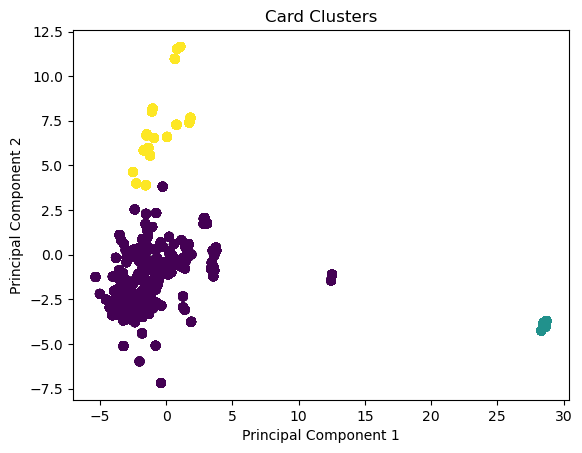

0.24528211948658685

In [3]:
def ohe_bootstrap(sample_size):
    bootstrap_df = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)
    print(f"Original df shape: {bootstrap_df.shape}")
    
    col_types = bootstrap_df.dtypes
    num_cols = col_types[col_types != 'object'].index.tolist()
    obj_cols = col_types[col_types == 'object'].index.tolist()
    
    # Handle cases where no bootstrapping desired
    if sample_size > 0:
        bootstrap_samples = []
        for _ in range(sample_size):
            bootstrap_sample = bootstrap_df.sample(n=len(bootstrap_df), replace=True, random_state = 42)
            bootstrap_samples.append(bootstrap_sample)
        bootstrap_df = pd.concat(bootstrap_samples, ignore_index=True)
        print(f"Original df shape after bootstrapping: {bootstrap_df.shape}")
    elif sample_size == 0:
        print(f"No bootstrapping; df shape unchanged: {bootstrap_df.shape}")

    # One-Hot-Encoding Object Features
    cols_to_encode = ['Availability of Credit Card Plan','Requirements for Opening','Index',
                  'Balance Transfer Grace Period','Minimum Finance Charge?','Purchase Transaction Fees',
                  'Balance Transfer Fees?','Cash Advance Fees?','Foreign Transaction Fees?']
    
    ohe_bootstrap_df = pd.get_dummies(bootstrap_df, columns = cols_to_encode)
    bootstrap_df = pd.concat([ohe_bootstrap_df, bootstrap_df], axis = 1)
        
    # Filtering out features which have not been OHE or numeric to begin with
    col_types = bootstrap_df.dtypes
    num_cols = col_types[col_types != 'object'].index.tolist()
    bootstrap_df = bootstrap_df[num_cols]
    print(f"Shape after OHE and bootstrapping: {bootstrap_df.shape}")

    knn = KNNImputer(missing_values=np.nan, n_neighbors=4,metric='nan_euclidean')
    bootstrap_data = knn.fit_transform(bootstrap_df)
    transformed_bootstrap_df = pd.DataFrame(data=bootstrap_data,columns=knn.get_feature_names_out())
    
    sc = StandardScaler()
    bootstrap_data_scaled = sc.fit_transform(transformed_bootstrap_df)

    kmeans = KMeans(n_clusters=3, random_state=42)
    bootstrap_df['cluster'] = kmeans.fit_predict(bootstrap_data_scaled)

    pca = PCA(n_components=2)
    bootstrap_data_2d = pca.fit_transform(bootstrap_data_scaled)
    
    plt.scatter(bootstrap_data_2d[:, 0], bootstrap_data_2d[:, 1], c=bootstrap_df['cluster'], cmap='viridis')
    plt.title('Card Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    
    sil = silhouette_score(bootstrap_data_scaled, bootstrap_df["cluster"])
    sil
    
    return sil

Original df shape: (648, 42)
No bootstrapping; df shape unchanged: (648, 42)
Shape after OHE and bootstrapping: (648, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


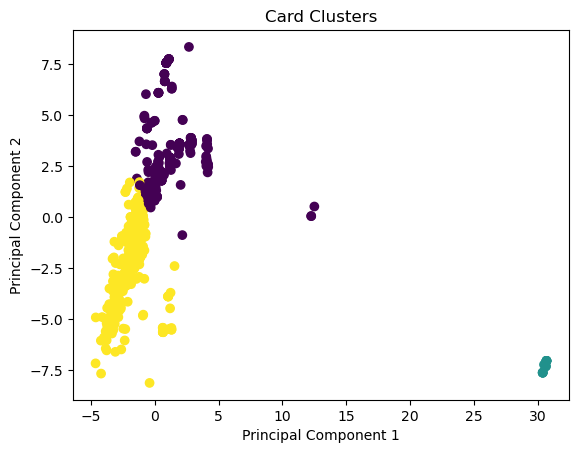

0.16017654976573295

In [4]:
ohe_bootstrap(0)

Original df shape: (648, 42)
No bootstrapping; df shape unchanged: (648, 42)
Shape after OHE and bootstrapping: (648, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


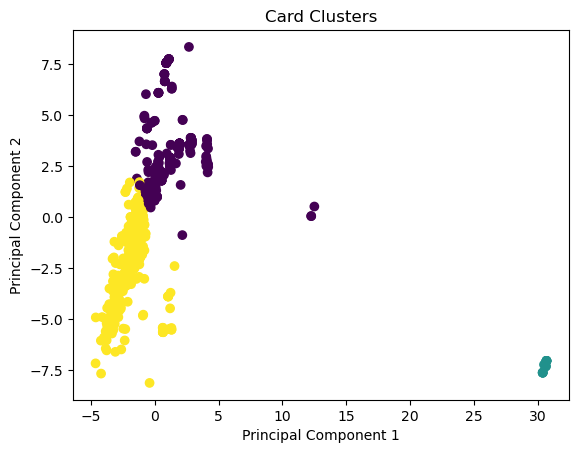

0.16017654976573295

In [5]:
ohe_bootstrap(0)

Original df shape: (648, 42)
Original df shape after bootstrapping: (64800, 42)
Shape after OHE and bootstrapping: (64800, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


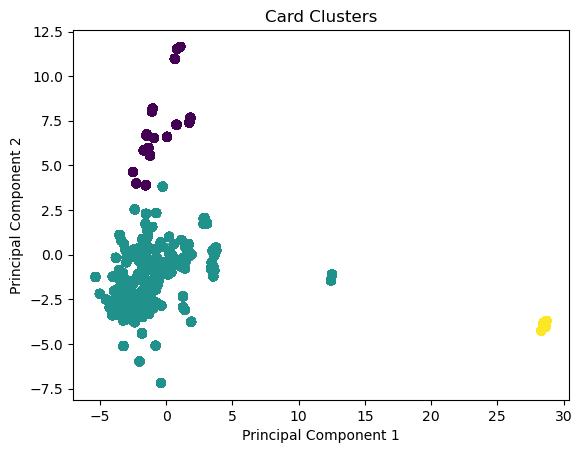

0.24530401522925843

In [7]:
ohe_bootstrap(100)

Original df shape: (648, 42)
Original df shape after bootstrapping: (97200, 42)
Shape after OHE and bootstrapping: (97200, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


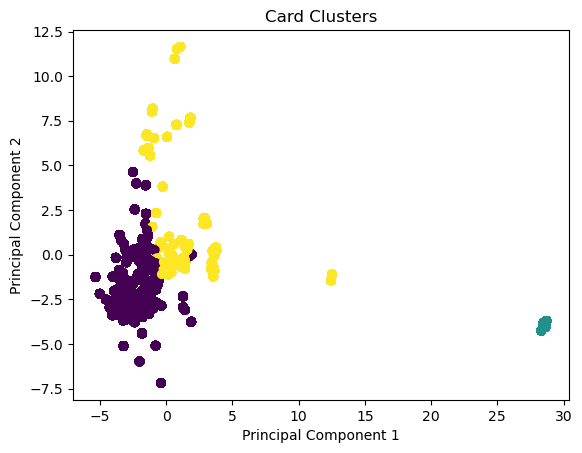

0.16827960362383626

In [10]:
ohe_bootstrap(150)

Original df shape: (648, 42)
Original df shape after bootstrapping: (129600, 42)
Shape after OHE and bootstrapping: (129600, 107)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


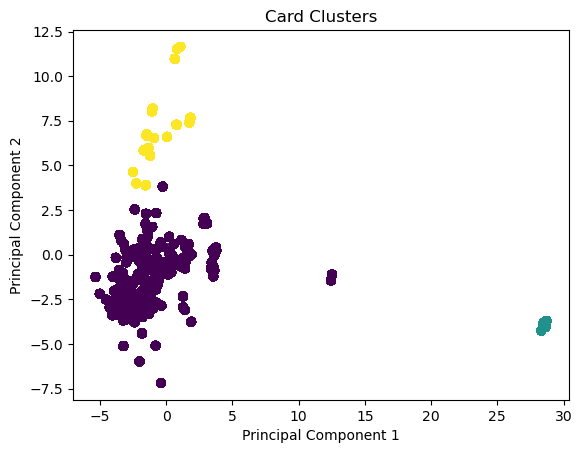

0.24531493579224353

In [11]:
ohe_bootstrap(200)

**Notes:** Create aggregate credit cards

**Bootstrapping without OHE features**

In [13]:
def num_bootstrap(sample_size):
    bootstrap_df = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)
    print(f"Original df shape: {bootstrap_df.shape}")
    
    col_types = bootstrap_df.dtypes
    num_cols = col_types[col_types != 'object'].index.tolist()
    obj_cols = col_types[col_types == 'object'].index.tolist()
    
    # Handle cases where no bootstrapping desired
    if sample_size > 0:
        bootstrap_samples = []
        for _ in range(sample_size):
            bootstrap_sample = bootstrap_df.sample(n=len(bootstrap_df), replace=True, random_state = 42)
            bootstrap_samples.append(bootstrap_sample)
        bootstrap_df = pd.concat(bootstrap_samples, ignore_index=True)
        print(f"Original df shape after bootstrapping: {bootstrap_df.shape}")
    elif sample_size == 0:
        print(f"No bootstrapping; df shape unchanged: {bootstrap_df.shape}")

    bootstrap_df = bootstrap_df[num_cols]
    print(f"Shape after selecting nums and bootstrapping: {bootstrap_df.shape}")

    knn = KNNImputer(missing_values=np.nan, n_neighbors=4,metric='nan_euclidean')
    bootstrap_data = knn.fit_transform(bootstrap_df)
    transformed_bootstrap_df = pd.DataFrame(data=bootstrap_data,columns=knn.get_feature_names_out())
    
    sc = StandardScaler()
    bootstrap_data_scaled = sc.fit_transform(transformed_bootstrap_df)

    kmeans = KMeans(n_clusters=3, random_state=42)
    bootstrap_df['cluster'] = kmeans.fit_predict(bootstrap_data_scaled)

    pca = PCA(n_components=2)
    bootstrap_data_2d = pca.fit_transform(bootstrap_data_scaled)
    
    plt.scatter(bootstrap_data_2d[:, 0], bootstrap_data_2d[:, 1], c=bootstrap_df['cluster'], cmap='viridis')
    plt.title('Card Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    
    sil = silhouette_score(bootstrap_data_scaled, bootstrap_df["cluster"])
    sil
    
    return sil

Original df shape: (648, 42)
No bootstrapping; df shape unchanged: (648, 42)
Shape after selecting nums and bootstrapping: (648, 22)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


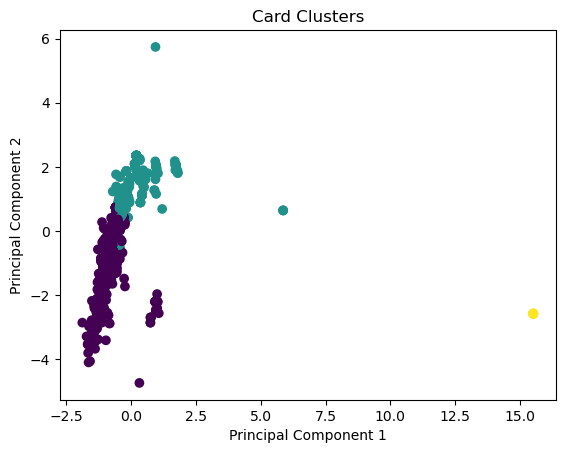

0.1825717452181311

In [14]:
num_bootstrap(0)

Original df shape: (648, 42)
Original df shape after bootstrapping: (32400, 42)
Shape after selecting nums and bootstrapping: (32400, 22)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


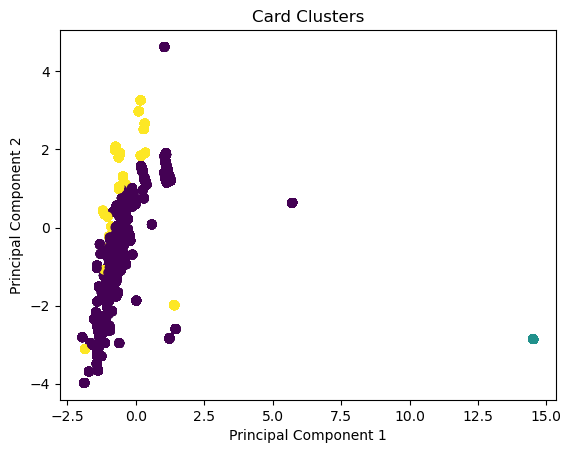

0.29630426870205206

In [15]:
num_bootstrap(50)

Original df shape: (648, 42)
Original df shape after bootstrapping: (64800, 42)
Shape after selecting nums and bootstrapping: (64800, 22)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


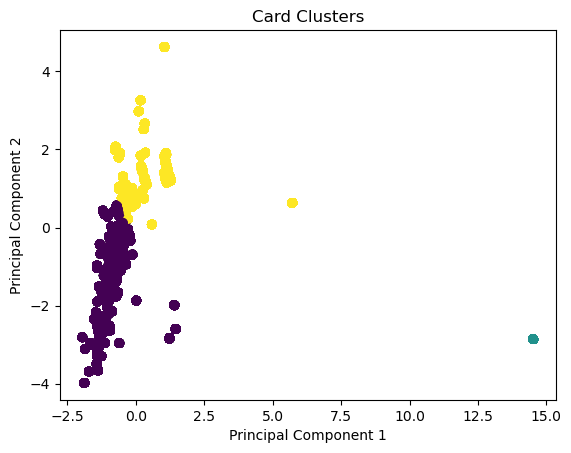

0.19812942436041261

In [16]:
num_bootstrap(100)

Original df shape: (648, 42)
Original df shape after bootstrapping: (97200, 42)
Shape after selecting nums and bootstrapping: (97200, 22)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


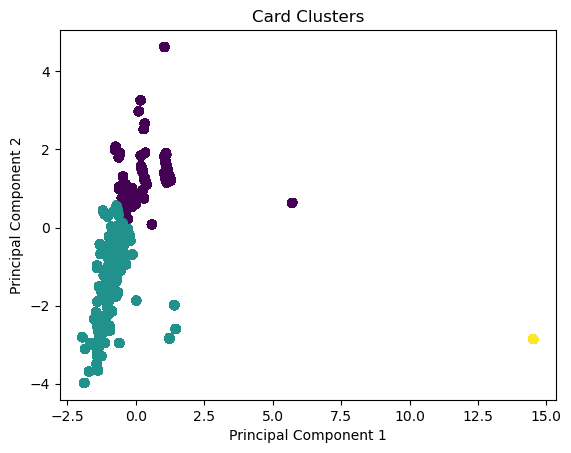

0.1981376932047127

In [17]:
num_bootstrap(150)

Original df shape: (648, 42)
Original df shape after bootstrapping: (129600, 42)
Shape after selecting nums and bootstrapping: (129600, 22)


C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


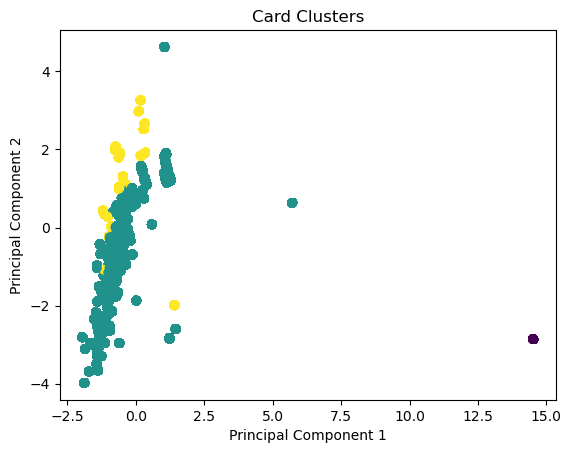

0.2778913311251626

In [18]:
num_bootstrap(200)

Chris' version of the dataset is overall performing much more consistently. I'll use his version.